In [162]:
import os
import sys
import math
import json
import time
from collections import defaultdict
import matplotlib.pyplot as plt

import networkx as nx

from tweepy import API
from tweepy import OAuthHandler
from tweepy import Cursor
from tweepy import TweepError

%matplotlib inline

# NetworkX 

In [42]:
G = nx.MultiDiGraph()
G.add_node('jorge')
G.add_node('katie')
G.add_edge('jorge', 'katie')

G.add_node('susana')
G.add_edge('jorge', 'susana')

G.add_node('alejandro')
G.add_edge('katie', 'alejandro')
G.add_edge('jorge', 'alejandro')

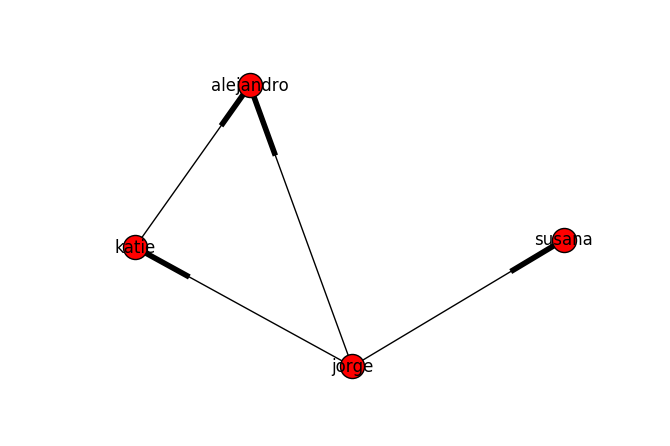

In [43]:
nx.draw(G, with_labels=True)

# Authentication

In [163]:
consumer_key    = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
access_token    = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_secret   = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

def get_twitter_auth():
    """Setup Twitter Authentication.
    
    Return: tweepy.OAuthHandler object
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth
    
def get_twitter_client():
    """Setup Twitter API Client.
    
    Return: tweepy.API object
    """
    auth = get_twitter_auth()
    client = API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)
    return client

api = get_twitter_client()

# Functions

In [164]:
def makedir(screen_name):
    dirname = 'users/{}'.format(screen_name)

    try:
        os.makedirs(dirname, mode=0o755, exist_ok=True)
    except OSError:
        print('Directory {} already exists.'.format(dirname))
    except Exception as e:
        print('Error while creating directory {}'.format(dirname))
        print(e)
        sys.exit(1)

def paginate(items, n):
    """Generate n-sized chunks for items."""
    for i in range(0, len(items), n):
        yield items[i:i+n]

In [181]:
def get_user_ff(client, screen_name, paginate_limit=10):
    """Get friends and followers for a given user.
    
    Return: users/{}/followers.jsonl and
            users/{}/friends.jsonl
    """
    # parameters
    if paginate_limit:
        limit_graph_size=True
    else:
        limit_graph_size=False
    
    # Make dir structure
    makedir(screen_name)
    
    t0 = time.time()
    # get followers for a given user
    fname = 'users/{}/followers.jsonl'.format(screen_name)
    with open(fname, 'w') as f:
        try:
            followers_chunks = Cursor(client.followers_ids, screen_name=screen_name)
            for followers in followers_chunks.pages():
                n = int( paginate_limit )
                for chunk in paginate(followers, n):
                    users = client.lookup_users(user_ids=chunk)
                    for user in users:
                        f.write(json.dumps(user._json)+'\n')
                    # Limit size of graph
                    if limit_graph_size:
                        break  
        except TweepError:
            print("More results available. Sleeping for 15 mins. to avoid rate limit")
            time.sleep(60*15)
           
    # get friends for a given user
    fname = 'users/{}/friends.jsonl'.format(screen_name)
    with open(fname, 'w') as f:
        try:
            friends_chunks = Cursor(client.friends_ids, screen_name=screen_name)
            for friends in friends_chunks.pages():
                n = int( paginate_limit )
                for chunk in paginate(friends, n):
                    users = client.lookup_users(user_ids=chunk)
                    for user in users:
                        f.write(json.dumps(user._json)+'\n')
                    # Limit size of graph
                    if limit_graph_size:
                        break
        except TweepError:
            print("More results available. Sleeping for 15 mins. to avoid rate limit")
            time.sleep(60*15)
        
    t1 = time.time()
    print('\tEXEC TIME: {}'.format(t1 - t0))

# Process Data

## Input Parameter

In [179]:
seed_screen_name = 'kraflab'
paginate_limit = 6

## Central Node

In [180]:
# Center node
seed_user = api.lookup_users(screen_names=[seed_screen_name])
seed = seed_user[0]
    
# get followers and friends for central node
get_user_ff(api, seed_screen_name, paginate_limit=paginate_limit)

# Build Graph
followers_file_seed = 'users/{}/followers.jsonl'.format(seed_screen_name)
friends_file_seed = 'users/{}/friends.jsonl'.format(seed_screen_name)
with open(followers_file_seed) as f1, open(friends_file_seed) as f2:     
    hfollowers = defaultdict(lambda: 0)
    
    graph = nx.MultiDiGraph()
    graph.add_node(seed.screen_name, followers=int(seed.followers_count))
    
    # Add followers to network
    for line in f1:
        profile = json.loads(line)
        # Add Node
        if profile['screen_name'] not in graph:
            graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
            
        # Add Edge
        if not graph.has_edge(seed.screen_name, profile['screen_name']):
            graph.add_edge(seed.screen_name, profile['screen_name'], followers=int(profile['followers_count']))
        hfollowers[profile['screen_name']] = int(profile['followers_count'])
            
    # Add friends to network
    for line in f2:
        profile = json.loads(line)
        # Add Node
        if profile['screen_name'] not in graph:
            graph.add_node(profile['screen_name'],followers=int(profile['followers_count']))
            
        # Add Edge
        if not graph.has_edge(profile['screen_name'], seed.screen_name):
            graph.add_edge(profile['screen_name'], seed.screen_name, followers=int(profile['followers_count']))
        hfollowers[profile['screen_name']] = int(profile['followers_count'])

50 6
	EXEC TIME: 0.8096737861633301


## Adding Degrees of Separation

In [182]:
# get friends and followers for each friend of the central node
with open(friends_file_seed) as f:    
    for line in f:
        profile_cent = json.loads(line)
            
        # get followers and friends for given user
        ##print('------------------------------------------------', profile_cent['screen_name'])
        get_user_ff(api, profile_cent['screen_name'], paginate_limit=paginate_limit)

        # Grow Network
        followers_file = 'users/{}/followers.jsonl'.format(profile_cent['screen_name'])
        friends_file = 'users/{}/friends.jsonl'.format(profile_cent['screen_name'])
        with open(followers_file) as f1, open(friends_file) as f2:
            
            # Add followers of given follower to network
            for line in f1:
                profile = json.loads(line)
                
                # Add Node
                if profile['screen_name'] not in graph:
                    graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                    
                # Add Edge
                if not graph.has_edge(profile_cent['screen_name'], profile['screen_name']):
                    graph.add_edge(profile_cent['screen_name'], profile['screen_name'], 
                                   followers=int(profile['followers_count']))
                hfollowers[profile['screen_name']] = int(profile['followers_count'])

            # Add friends of given follower to network
            for line in f2:
                profile = json.loads(line)
                
                # Add Node
                if profile['screen_name'] not in graph:
                    graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                    
                # Add Edge
                if not graph.has_edge(profile['screen_name'], profile_cent['screen_name']):
                    graph.add_edge(profile['screen_name'], profile_cent['screen_name'],
                                   followers=int(profile['followers_count']))
                hfollowers[profile['screen_name']] = int(profile['followers_count'])

------------------------------------------------ letsencrypt
	EXEC TIME: 6.16911506652832
------------------------------------------------ dhh
Rate limit reached. Sleeping for: 870
Rate limit reached. Sleeping for: 894
Rate limit reached. Sleeping for: 893
	EXEC TIME: 2692.717442035675
------------------------------------------------ SunyshoreStore
	EXEC TIME: 1.1816484928131104
------------------------------------------------ WayForward
Rate limit reached. Sleeping for: 891
	EXEC TIME: 900.3152046203613
------------------------------------------------ aprilmpls
	EXEC TIME: 1.0557973384857178
------------------------------------------------ bcrypt
Rate limit reached. Sleeping for: 893
	EXEC TIME: 901.8494918346405


In [183]:
# get friends and followers for each friend of the central node
with open(followers_file_seed) as f:    
    for line in f:
        profile_cent = json.loads(line)
            
        # get followers and friends for given user
        get_user_ff(api, profile_cent['screen_name'], paginate_limit=paginate_limit)

        # Grow Network
        followers_file = 'users/{}/followers.jsonl'.format(profile_cent['screen_name'])
        friends_file = 'users/{}/friends.jsonl'.format(profile_cent['screen_name'])
        with open(followers_file) as f1, open(friends_file) as f2:
            
            # Add followers of given follower to network
            for line in f1:
                profile = json.loads(line)
                
                # Add Node
                if profile['screen_name'] not in graph:
                    graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                    
                # Add Edge
                if not graph.has_edge(profile_cent['screen_name'], profile['screen_name']):
                    graph.add_edge(profile_cent['screen_name'], profile['screen_name'], 
                                   followers=int(profile['followers_count']))
                hfollowers[profile['screen_name']] = int(profile['followers_count'])

            # Add friends of given follower to network
            for line in f2:
                profile = json.loads(line)
                
                # Add Node
                if profile['screen_name'] not in graph:
                    graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                    
                # Add Edge
                if not graph.has_edge(profile['screen_name'], profile_cent['screen_name']):
                    graph.add_edge(profile['screen_name'], profile_cent['screen_name'],
                                   followers=int(profile['followers_count']))
                hfollowers[profile['screen_name']] = int(profile['followers_count'])

	EXEC TIME: 1.052950382232666
	EXEC TIME: 0.9473190307617188
	EXEC TIME: 1.1742825508117676
	EXEC TIME: 1.6095411777496338
	EXEC TIME: 1.0254428386688232
	EXEC TIME: 1.0700361728668213


In [184]:
print(nx.info(graph))

Name: 
Type: MultiDiGraph
Number of nodes: 557
Number of edges: 562
Average in degree:   1.0090
Average out degree:   1.0090


# Visualization

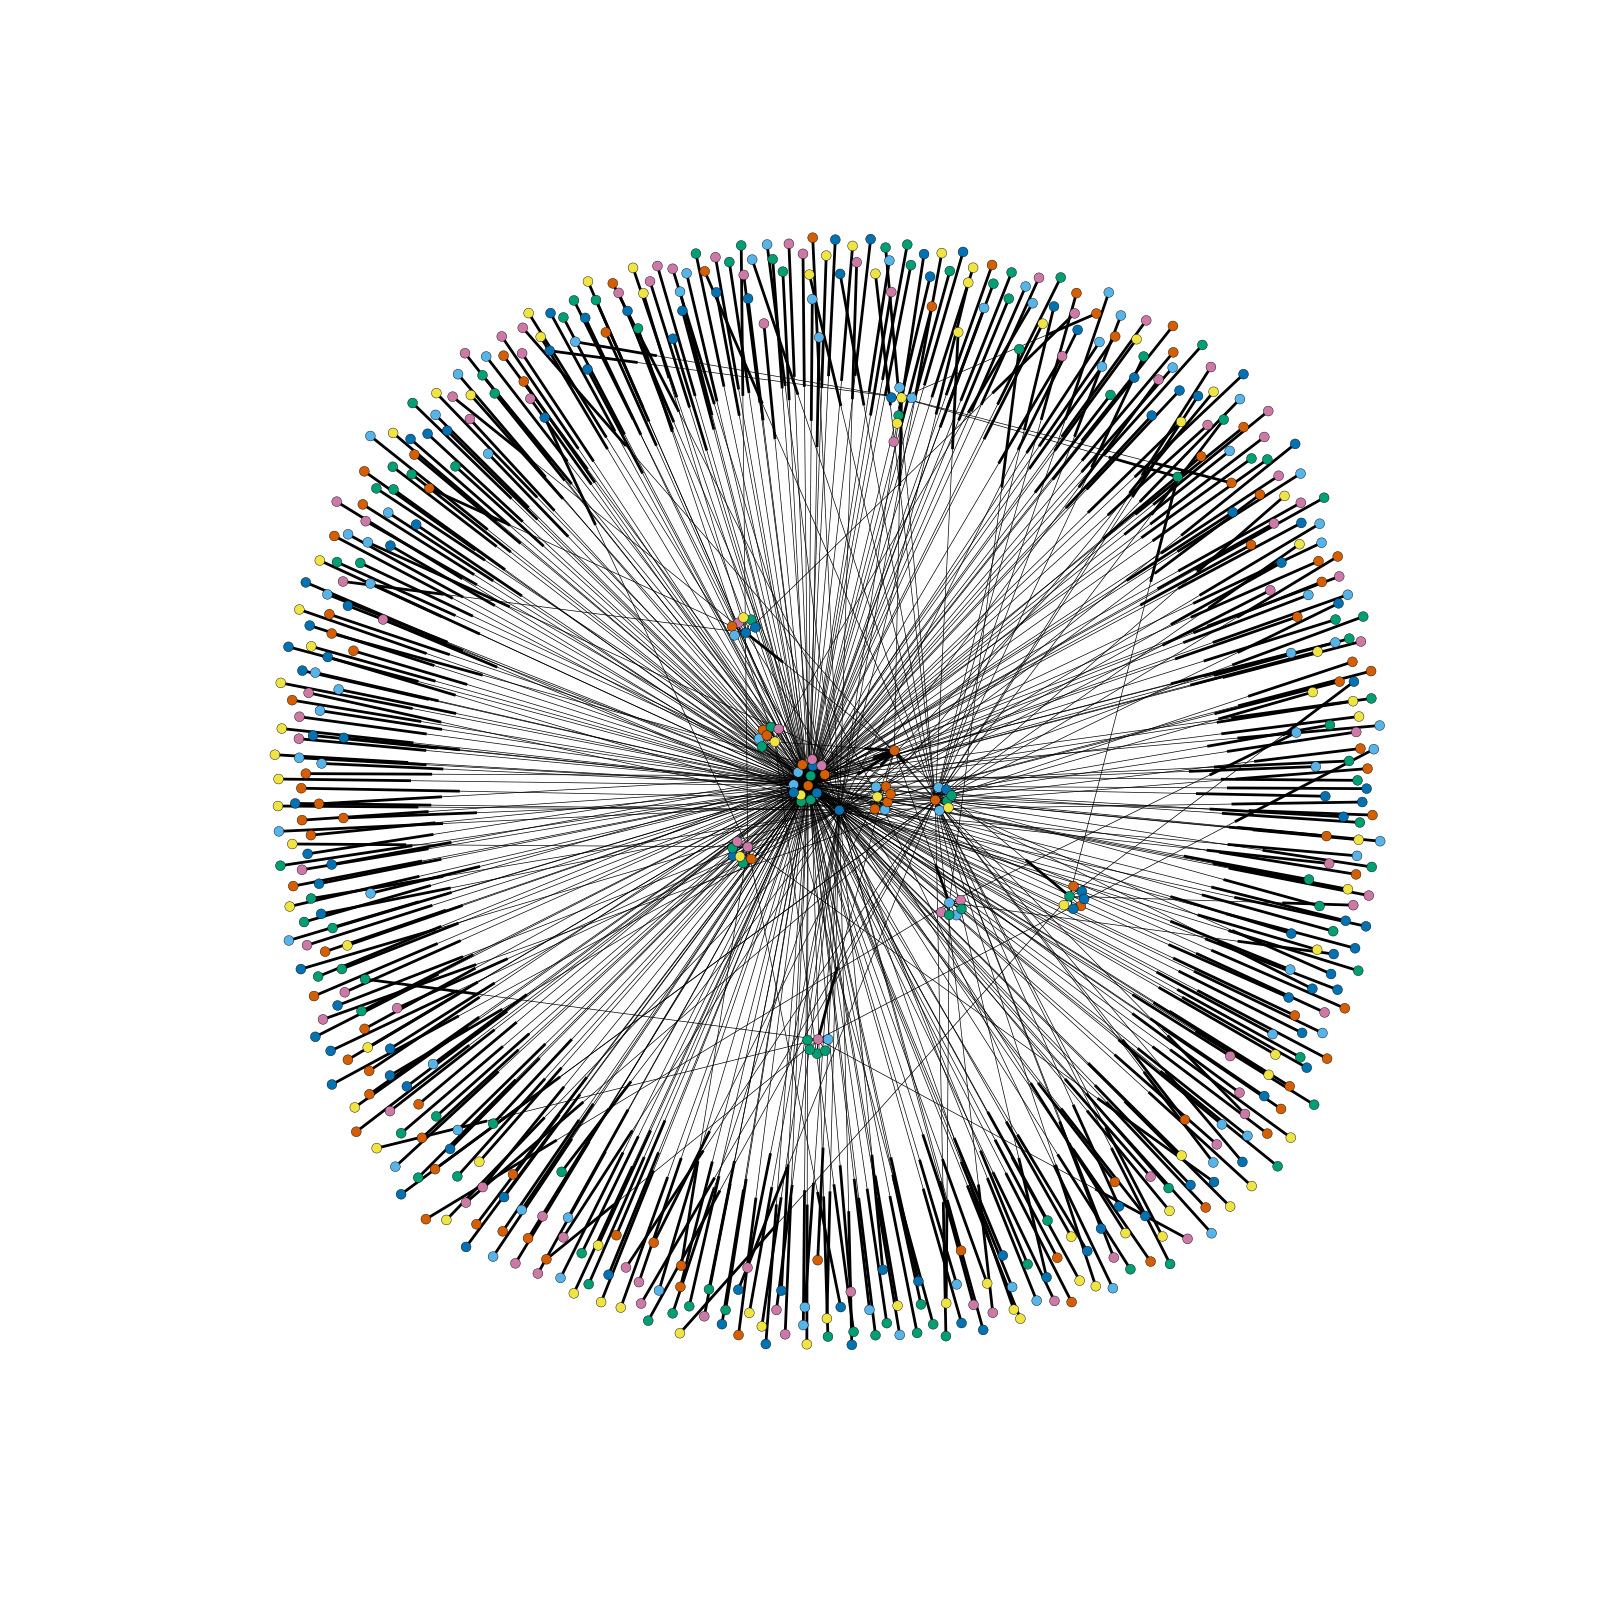

{0: '#0072b2', 1: '#009e73', 2: '#d55e00', 3: '#cc79a7', 4: '#f0e442', 5: '#56b4e9', 6: '#0072b2', 7: '#009e73', 8: '#d55e00', 1033: '#cc79a7', 10: '#f0e442', 11: '#56b4e9', 12: '#0072b2', 13: '#009e73', 14: '#0072b2', 15: '#cc79a7', 16: '#f0e442', 17: '#56b4e9', 18: '#0072b2', 19: '#009e73', 20: '#d55e00', 21: '#cc79a7', 22: '#f0e442', 23: '#56b4e9', 24: '#0072b2', 25: '#009e73', 26: '#d55e00', 2587: '#009e73', 28: '#f0e442', 1053: '#56b4e9', 30: '#0072b2', 32: '#d55e00', 33: '#cc79a7', 34: '#f0e442', 35: '#56b4e9', 36: '#0072b2', 37: '#009e73', 38: '#d55e00', 40: '#f0e442', 4137: '#56b4e9', 42: '#009e73', 43: '#009e73', 44: '#d55e00', 45: '#cc79a7', 237614: '#0072b2', 47: '#56b4e9', 48: '#0072b2', 561: '#f0e442', 50: '#d55e00', 51: '#0072b2', 52: '#56b4e9', 498: '#f0e442', 9: '#f0e442', 56: '#d55e00', 569: '#cc79a7', 58: '#f0e442', 59: '#56b4e9', 60: '#0072b2', 61: '#009e73', 62: '#d55e00', 64: '#f0e442', 65: '#56b4e9', 66: '#0072b2', 67: '#009e73', 68: '#d55e00', 1095: '#f0e442', 72

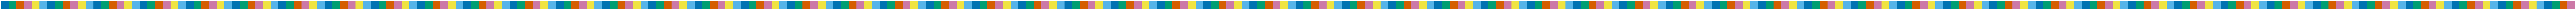

In [187]:
from seaborn import color_palette, set_style, palplot

def create_color_map(G, attribute, seaborn_palette="colorblind"):
    """Return a list of hex color mappings for node attributes"""
    attributes = [G.node[label][attribute] for label in G.nodes()]

    # get the set of possible attributes
    attributes_unique = list(set(attributes))
    num_values = len(attributes_unique)

    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, num_values).as_hex()

    # create a mapping of attribute to color
    color_map = dict(zip(attributes_unique, palette))

    # map the attribute for each node to the color it represents
    node_colors = [color_map[attribute] for attribute in attributes]

    return node_colors, color_map, palette

node_colors, color_map, palette = create_color_map(graph, 'followers')

set_style('white')
plt.figure(figsize=(20,20))
plt.axis('off')

layout = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, layout, node_color=node_colors, node_size=50)
#nx.draw_networkx_labels(graph, pos=layout, font_size=16)
nx.draw_networkx_edges(graph, layout, width=0.5)

plt.savefig('twitter_graph.png')
plt.show()

# legend
##print(color_map)
##palplot(palette)

# Structure of a User's Profile

In [6]:
fname = 'users/X1alejandro3x/friends.jsonl'
f =open(fname, 'r')
a = f.readlines()
print(json.dumps(json.loads(a[0]), indent=4))

{
    "contributors_enabled": false,
    "id": 3312757710,
    "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png",
    "profile_sidebar_border_color": "000000",
    "profile_image_url_https": "https://pbs.twimg.com/profile_images/639105973244719104/Q9_rKL9J_normal.png",
    "screen_name": "LearnDataSci",
    "geo_enabled": false,
    "status": {
        "favorite_count": 1,
        "in_reply_to_user_id": 428802983,
        "lang": "en",
        "id": 824715650220392449,
        "in_reply_to_status_id": 819680865844428801,
        "in_reply_to_screen_name": "classcentral",
        "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
        "created_at": "Thu Jan 26 20:28:28 +0000 2017",
        "retweeted": false,
        "in_reply_to_status_id_str": "819680865844428801",
        "retweet_count": 0,
        "geo": null,
        "is_quote_status": false,
        "truncated": true,
        "place": null,
        "id_st